In [1]:
import scipy.io as scio
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

from sklearn.decomposition import PCA

sns.set()
import time
import cProfile
import psutil
%load_ext memory_profiler

In [2]:
random.seed(3345)

In [3]:
def distance_feature(x): # calcuate distance between points, choose uprigt triangle
    #sqrt(dx^2+dy^2)
    a = (x[None, :, :] - x[:, None, :])
    b = np.linalg.norm(a, axis=2)
    return b[np.triu_indices(78, 1)] # feature size (78-1)(78-2) /2 

In [4]:
def euc_distance_feature(x): # instead of distance, keep two dimensional distance vector
    #(dx,dy)
    a = (x[None, :, :] - x[:, None, :])
    index = np.triu_indices(78, 1)
    b = a[index]
    return b.reshape((-1,)) # feature size (78-1)(78-2) /2 * 2

In [5]:
df = pd.read_csv("../../data/train_set/label.csv")
labels = df["emotion_idx"].to_list()

In [6]:
data = list()
for i in range(1, 2501):
    name = "../../data/train_set/points/%04d.mat" % i
    dic = scio.loadmat(name)
    if "faceCoordinatesUnwarped" in dic:
        data.append(dic["faceCoordinatesUnwarped"])
    else:
        data.append(dic["faceCoordinates2"])

In [7]:
# shuffle data
data, labels = shuffle(data, labels, random_state=0)

### First we try the distance as features 

In [8]:
features = [distance_feature(d) for d in data]

In [9]:
len(features[0])

3003

In [10]:
distance_feature(data[0])

array([ 36.34978226,  22.49500156,   8.99027133, ...,  53.06069409,
       105.97379197,  52.97335008])

In [11]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.2)

Logistic Regression

In [12]:
import os

mem_logreg1 = psutil.Process(os.getpid())
print(mem_logreg1.memory_info().rss)

#time before
start = time.time()


clf = LogisticRegression(max_iter=800, penalty = "l2", random_state=0, solver='lbfgs', multi_class='multinomial', n_jobs=-1).fit(train_x, train_y)


#time after
end = time.time()
print("%s seconds"%(end - start))

time_logreg = end - start

#print((psutil.virtual_memory())
mem_logreg2 = psutil.Process(os.getpid())
print(mem_logreg2.memory_info().rss)

213188608
47.02760696411133 seconds
279678976


In [15]:
clf.score(test_x, test_y)

0.52

Random Forest

In [16]:
#time before
start = time.time()

forest = RandomForestClassifier(n_estimators=500, oob_score = True, 
                                max_depth=12, max_leaf_nodes=15,
                                max_features="auto", n_jobs=-1)


In [17]:
forest.fit(train_x, train_y)

#time after
end = time.time()
print("%s seconds"%(end - start))

time_forest = end - start

print(forest.score(train_x, train_y))
print(forest.score(test_x, test_y))
print(forest.oob_score_)

11.14839220046997 seconds
0.4745
0.328
0.3295


### Second we try Euclidian distance as features

In [18]:
features2 = [euc_distance_feature(d) for d in data]

In [19]:
train_x, test_x, train_y, test_y = train_test_split(features2, labels, test_size=0.2)

In [20]:
#time before
start = time.time()
clf = LogisticRegression(max_iter=800, random_state=0,  penalty = "l2", solver='lbfgs', multi_class='multinomial', n_jobs=-1).fit(train_x, train_y)

#time after
end = time.time()
print("%s seconds"%(end - start))

time_log_reg_euc = end - start

104.71444606781006 seconds


In [21]:
clf.score(train_x, train_y)

0.871

In [22]:
clf.score(test_x, test_y)

0.482

In [33]:
### KNN

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(features2, labels, test_size=0.2)

In [ ]:
neighbors = np.arange(5, 50, 10) 
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
  
# Loop over K values 
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(train_x, train_y) 
      
    # Compute traning and test data accuracy 
    train_accuracy[i] = knn.score(train_x, train_y) 
    test_accuracy[i] = knn.score(test_x, test_y) 
  
# Generate plot 
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show() 

In [34]:
#time before
start = time.time()

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(train_x, train_y) 

#time after
end = time.time()
print("%s seconds"%(end - start))

time_KN_euc = end - start

1.0151429176330566 seconds


In [ ]:
print("Training dataset Accuracy")
train_accuracy = knn.score(train_x, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = knn.score(test_x, test_y) 
print(test_accuracy)

In [ ]:
#time before
start = time.time()

pca = PCA(n_components=48).fit(train_x)
train_x_reduce = pca.transform(train_x)

end = time.time()
print("%s seconds"%(end - start))

time_KN_pca = end - start

In [ ]:
#time before
start = time.time()

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(train_x_reduce, train_y) 

end = time.time()
print("%s seconds"%(end - start))

time_KN_reduced = end - start

In [ ]:
print("Training dataset Accuracy")
train_accuracy = knn.score(train_x_reduce, train_y) 
print(train_accuracy)
print("Testing dataset Accuracy")
test_accuracy = knn.score(pca.transform(test_x), test_y) 
print(test_accuracy)

xgboost

In [23]:
#import xgboost as xgb

In [24]:
#D_train = xgb.DMatrix(train_x, label=train_y)
#D_test = xgb.DMatrix(test_x, label=test_y)

In [25]:
#clf = xgb.XGBClassifier()
#parameters = {
#     "eta"    : [0.10, 0.20, 0.30 ],
#     "max_depth"        : [ 3, 5,8,10,12],
#     "min_child_weight" : [ 1, 3, 5, 7],
#     "gamma"            : [ 0.0, 0.2 , 0.4],
#     "colsample_bytree" : [ 0.3, 0.5 , 0.7]
#     }

#grid = GridSearchCV(clf,
#                    parameters, n_jobs=4,
#                    scoring="neg_log_loss",
#                    cv=3)

#grid.fit(train_x, train_y)

#print("Best parameters set found:")
#print(grid.best_params_)
#best_params = grid.best_params_


In [26]:
#time before
#start = time.time()
#xgb = xgb.XGBClassifier(best_params).fit(train_x, train_y)

#time after
#end = time.time()
#print("%s seconds"%(end - start))

#time_xgb_euc = end - start

In [27]:
#xgb.score(train_x, train_y)

In [28]:
#xgb.score(test_x, test_y)

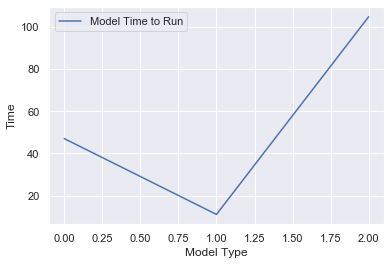

In [32]:
#Time Plot
# Generate plot 
model_time = ([time_logreg, time_forest, time_log_reg_euc, time_KN_euc, time_KN_pca, time_KN_reduced])
plt.plot(model_time, label = 'Model Time to Run') 
  
plt.legend() 
plt.xlabel('Model Type') 
plt.ylabel('Time') 
plt.show() 